# Portfolio Optimization

In [1]:
!pip install yfinance
!pip install cvxpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import cvxpy as cp

## Class definition

In [3]:
class Portfolio:
    def __init__(self, tickers, start_date, end_date, q=10):
        """
        Initialize the Portfolio class.
        
        tickers: List of asset tickers. Note that yfinance downloads tickers in alphabetical order.
        start_date: string like '2025-01-01'.
        end_date: string like '2025-02-01'.
        q: Risk aversion parameter (default is 10).
        """
        self.tickers = sorted(tickers) # !yfinance download tickers alphabetically
        self.start_date = start_date
        self.end_date = end_date
        self.q = q
        self.n = len(tickers)
        self.data = None
        self.returns = None
        self.r = None
        self.sigma = None
        self.fetch_data()
    
    def get_tickers(self):
        """Return the tickers."""
        return self.tickers

    def fetch_data(self):
        """Fetch historical price data, calculate returns, r and sigma."""
        self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date)
        self.data = self.data['Close']
        self.returns = self.data.pct_change().dropna()
        self.r = self.returns.mean(axis=0).values
        self.sigma = self.returns.cov().values

    def calculate_optimal_x(self):
        """
        Calculate the optimal portfolio weights x (original way).
        """
        e = np.ones(self.n)
        x = cp.Variable(self.n)
        obj = cp.Minimize(self.q * cp.quad_form(x, self.sigma) -  self.r @ x)
        constraints = [e @ x == 1, x >= 0]
        problem = cp.Problem(obj, constraints)
        problem.solve()
        return x.value
    
    def calculate_optimal_with_transaction_costs(self, x_init, f_buy, f_sell):
        """
        Calculate the optimal portfolio weights with transaction costs.
        
        x_init: Initial portfolio weights.
        f_buy: Buying transaction cost.
        f_sell: Selling transaction cost.
        """
        e = np.ones(self.n)
        u_buy = cp.Variable(self.n)
        u_sell = cp.Variable(self.n)
        x = x_init + u_buy - u_sell

        objective = cp.Minimize(self.q * cp.quad_form(x, self.sigma) - self.r @ x)
        constraints = [
            x == x_init + u_buy - u_sell,
            x >= 0,
            u_buy >= 0,
            u_sell >= 0,
            (1 - f_sell) * e @ u_sell == (1 + f_buy) * e @ u_buy,
            e @ x == 1
        ]

        problem = cp.Problem(objective, constraints)
        problem.solve()

        return x.value, u_buy.value, u_sell.value


## Model with Transaction Costs

\begin{align*}
    \min_{\mathbf{x}, \mathbf{u}_{\text{buy}}, \mathbf{u}_{\text{sell}}} & \quad q\cdot \mathbf{x}^T \Sigma \mathbf{x} + \mathbf{r}^T \mathbf{x}\\
    \text{subject to:} & \\
    & \mathbf{x} = \mathbf{x}_{\text{init}} + \mathbf{u}_{\text{buy}} - \mathbf{u}_{\text{sell}} \\
    & \mathbf{u}_{\text{buy}} \ge 0, \quad \mathbf{u}_{\text{sell}} \ge 0 \\
    & (1 - f_{\text{sell}}) \mathbf{1}^T \mathbf{u}_{\text{sell}} = (1 + f_{\text{buy}}) \mathbf{1}^T \mathbf{u}_{\text{buy}} \\
    & \mathbf{1}^T \mathbf{x} = 1
\end{align*}

Methods already written above.

### Analysis

In [32]:
tickers = ["TSLA", "NVDA", "AAPL", "JPM", "JNJ", "KO", "DUK", "T", "GE", "PFE"]  
portfolio = Portfolio(tickers,"2014-12-31","2024-12-31",10)
opt_x = portfolio.calculate_optimal_x()
x_init = np.full(10, 0.1)
opt_x_trans, *_ = portfolio.calculate_optimal_with_transaction_costs(x_init,0.0001,0.0001)

result_df = pd.DataFrame(
    [opt_x, x_init, opt_x_trans],
    columns=portfolio.get_tickers(),
    index=["Ordinary Portfolio", "Initial Portfolio", "Transaction-Constrained Portfolio"]
).round(3)

result_df

[*********************100%***********************]  10 of 10 completed
/opt/conda/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


,AAPL,DUK,GE,JNJ,JPM,KO,NVDA,PFE,T,TSLA
Ordinary Portfolio,0.049,0.143,0.0,0.258,0.021,0.226,0.129,0.031,0.102,0.041
Initial Portfolio,0.100,0.100,0.1,0.100,0.100,0.100,0.100,0.100,0.100,0.100
Transaction-Constrained Portfolio,0.100,0.127,0.0,0.179,0.083,0.163,0.101,0.100,0.100,0.046


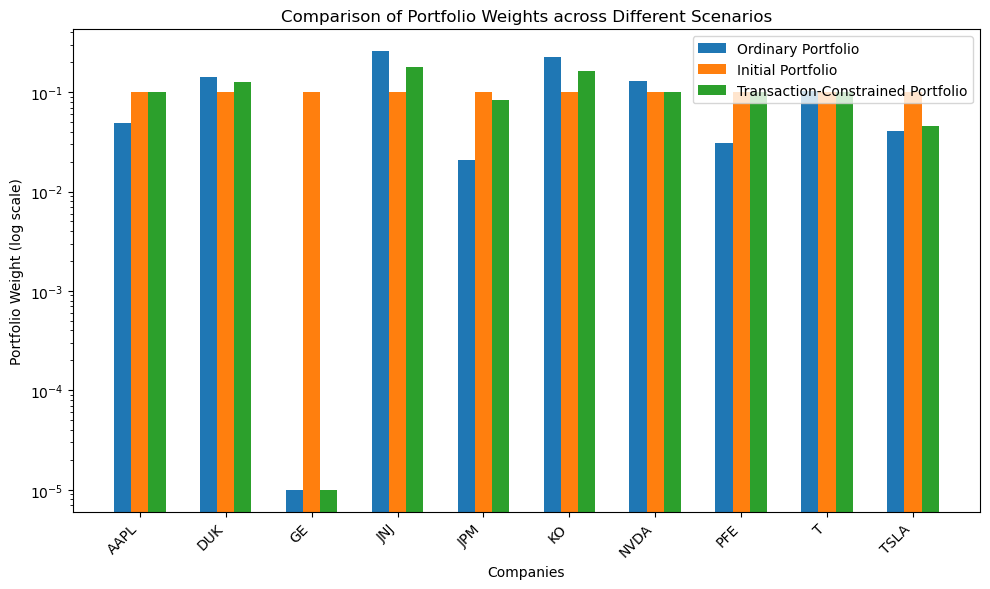

In [34]:
temp_df = result_df.copy()
temp_df = temp_df.mask(temp_df <= 0, 1e-5)

portfolios = temp_df.index    
assets = temp_df.columns      

n_assets = len(assets)        
n_portfolios = len(portfolios)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
indices = np.arange(n_assets)  # [0,1,2,...,9]


ax.bar(indices - bar_width,
       temp_df.iloc[0],
       width=bar_width,
       label=portfolios[0])


ax.bar(indices,
       temp_df.iloc[1],
       width=bar_width,
       label=portfolios[1])

if n_portfolios > 2:
    ax.bar(indices + bar_width,
           temp_df.iloc[2],
           width=bar_width,
           label=portfolios[2])


ax.set_xticks(indices)
ax.set_xticklabels(assets, rotation=45, ha='right')


ax.set_yscale("log")


ax.set_xlabel("Companies")
ax.set_ylabel("Portfolio Weight (log scale)")
ax.set_title("Comparison of Portfolio Weights across Different Scenarios")

ax.legend()

plt.tight_layout()
plt.show()


## Model allowing short positions

\begin{align*}
    \text{Minimize} \quad & q\cdot \mathbf{x}^T \Sigma \mathbf{x} + \mathbf{r}^T\mathbf{x} \\
    \text{subject to} \quad \\
    & \mathbf{x} = \mathbf{x}_{\text{long}} - \mathbf{x}_{\text{short}}, \\
    & \mathbf{x}_{\text{long}} \succeq 0, \quad \mathbf{x}_{\text{short}} \succeq 0, \\
    & \mathbf{1}^T \mathbf{x}_{\text{short}} \leq \eta \mathbf{1}^T \mathbf{x}_{\text{long}}, \\
    & \mathbf{1}^T \mathbf{x} = 1
\end{align*}

In [35]:
class PortfolioWithShort(Portfolio):
    def calculate_optimal_with_short(self, eta=0.5):
        """
        Calculate the optimal portfolio weights allowing short positions.
        
        eta: Maximum ratio of short positions to long positions (default is 0.5).
        """
        x_long = cp.Variable(self.n)
        x_short = cp.Variable(self.n)
        x = x_long - x_short

        objective = cp.Minimize(self.q * cp.quad_form(x, self.sigma) - self.r @ x)
        constraints = [
            x_long >= 0,
            x_short >= 0,
            cp.sum(x_short) <= eta*cp.sum(x_long),
            cp.sum(x) == 1
        ]

        problem = cp.Problem(objective, constraints)
        problem.solve()

        return x.value, x_long.value, x_short.value

In [40]:
tickers = ["TSLA", "NVDA", "AAPL", "JPM", "JNJ", "KO", "DUK", "T", "GE", "PFE"]  
port_short = PortfolioWithShort(tickers,"2014-12-31","2024-12-31",10)
opt_x = port_short.calculate_optimal_x()
opt_x_combined, opt_x_long, opt_x_short = port_short.calculate_optimal_with_short(0.5)

result_df = pd.DataFrame(
    [opt_x, opt_x_combined, opt_x_long, opt_x_short],
    columns=portfolio.get_tickers(),
    index=["Ordinary Portfolio", "Combined Portfolio", "Long Position", "Short Position"]
).round(3)

result_df

[*********************100%***********************]  10 of 10 completed


,AAPL,DUK,GE,JNJ,JPM,KO,NVDA,PFE,T,TSLA
Ordinary Portfolio,0.049,0.143,0.000,0.258,0.021,0.226,0.129,0.031,0.102,0.041
Combined Portfolio,0.051,0.146,-0.051,0.255,0.047,0.234,0.133,0.031,0.112,0.042
Long Position,0.088,0.163,0.033,0.342,0.067,0.301,0.188,0.070,0.130,0.077
Short Position,0.037,0.017,0.084,0.087,0.019,0.067,0.055,0.039,0.019,0.035


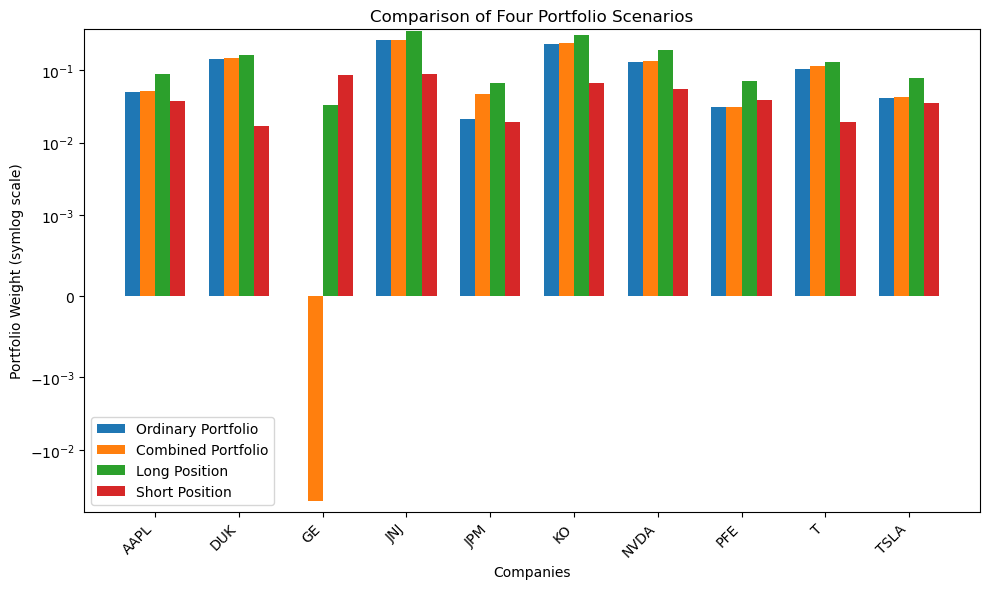

In [41]:

portfolios = result_df.index     
assets = result_df.columns         
n_assets = len(assets)

fig, ax = plt.subplots(figsize=(10, 6))


bar_width = 0.18
indices = np.arange(n_assets)


ax.bar(indices - 1.5 * bar_width,
       result_df.iloc[0],
       width=bar_width,
       label=portfolios[0])

ax.bar(indices - 0.5 * bar_width,
       result_df.iloc[1],
       width=bar_width,
       label=portfolios[1])

ax.bar(indices + 0.5 * bar_width,
       result_df.iloc[2],
       width=bar_width,
       label=portfolios[2])

ax.bar(indices + 1.5 * bar_width,
       result_df.iloc[3],
       width=bar_width,
       label=portfolios[3])

ax.set_xticks(indices)
ax.set_xticklabels(assets, rotation=45, ha='right')

ax.set_xlabel("Companies")
ax.set_ylabel("Portfolio Weight")
ax.set_title("Comparison of Four Portfolio Scenarios")


ax.set_yscale("linear")


ax.set_yscale("symlog", linthresh=1e-3)
ax.set_ylabel("Portfolio Weight (symlog scale)")

ax.legend()
plt.tight_layout()
plt.show()

## Model with Entropic Risk Measure

In [37]:
class PortfolioWithEntropicRisk(Portfolio):
    def calculate_optimal_with_entropicrisk(self):
        """
        Solve the entropic-risk minimization problem:
            minimize  (1/q)*log( (1/T)*∑ exp( -q * port_returns[t] ) )
            subject to:
                sum(weights) = 1
                weights >= 0
        """
        T, n = self.returns.shape
        
        x = cp.Variable(n, nonneg=True)

        port_ret = self.returns.values @ x

        entropic_expr = (1.0 / self.q) * (cp.log_sum_exp(-self.q * port_ret) - np.log(T))
        
        objective = cp.Minimize(entropic_expr)
        constraints = [cp.sum(x) == 1]
        
        problem = cp.Problem(objective, constraints)
        problem.solve()
 
        return x.value

In [38]:
tickers = ["TSLA", "NVDA", "AAPL", "JPM", "JNJ", "KO", "DUK", "T", "GE", "PFE"]  
port_entropic = PortfolioWithEntropicRisk(tickers,"2014-12-31","2024-12-31",10)
opt_x = port_entropic.calculate_optimal_x()
opt_x_entropic = port_entropic.calculate_optimal_with_entropicrisk()

result_df = pd.DataFrame(
    [opt_x, opt_x_entropic],
    columns=portfolio.get_tickers(),
    index=["Ordinary Portfolio", "Entropic Risk Portfolio"]
).round(3)

result_df

[*********************100%***********************]  10 of 10 completed


,AAPL,DUK,GE,JNJ,JPM,KO,NVDA,PFE,T,TSLA
Ordinary Portfolio,0.049,0.143,0.0,0.258,0.021,0.226,0.129,0.031,0.102,0.041
Entropic Risk Portfolio,0.047,0.166,0.0,0.223,0.044,0.134,0.253,0.000,0.076,0.057


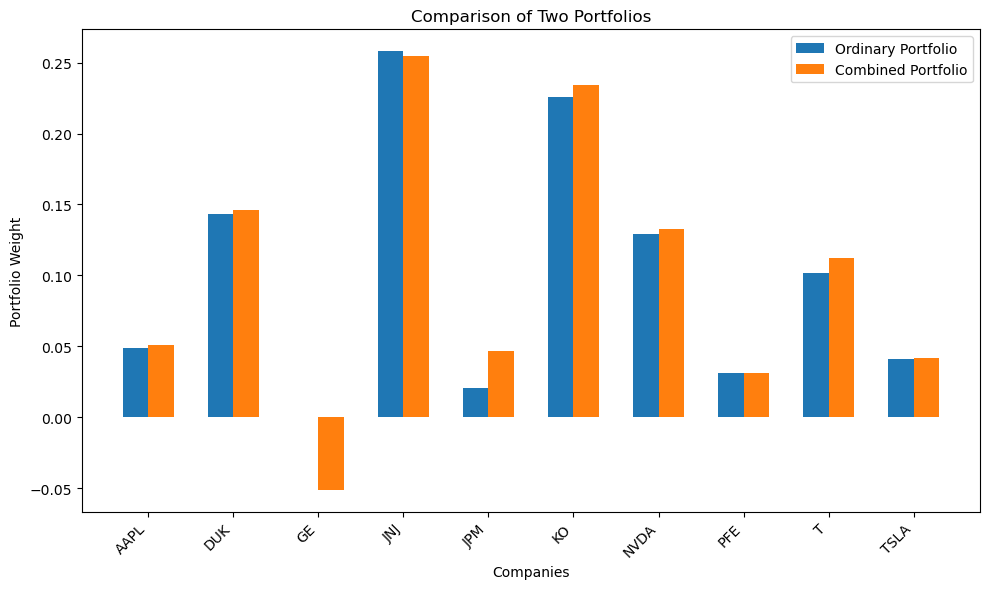

In [42]:
portfolios = result_df.index
assets = result_df.columns
n_assets = len(assets)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
indices = np.arange(n_assets)

ax.bar(indices - bar_width/2,
       result_df.iloc[0],
       width=bar_width,
       label=portfolios[0])

ax.bar(indices + bar_width/2,
       result_df.iloc[1],
       width=bar_width,
       label=portfolios[1])

ax.set_xticks(indices)
ax.set_xticklabels(assets, rotation=45, ha='right')
ax.set_xlabel("Companies")
ax.set_ylabel("Portfolio Weight")
ax.set_title("Comparison of Two Portfolios")
ax.legend()

plt.tight_layout()
plt.show()

## Portfolio with Drawdown constraints

Objective Function:

$$\min_\mathbf{x} -\mathbf{r}^T \mathbf{x}
$$

Subject to:
* $\mathbf{1}^T \mathbf{x} = 1$
* $\mathbf{x} \ge 0$
* $$\max_{s\le t} \{\mathbf{x}^T\mathbf{R}_s\} - \mathbf{x}^T\mathbf{R}_t \le \alpha, \quad \forall \, t \in [0,T]$$
where 
$$\mathbf{R}_t = \frac{\mathbf{p}_t-\mathbf{p}_0}{\mathbf{p}_0}$$

In [43]:
class DrawdownPortfolio(Portfolio):
    def __init__(self, tickers, start_date, end_date, q=10, alpha=0.05):
        """
        Initialize the DrawdownPortfolio class.

        tickers: List of asset tickers.
        start_date: string like '2025-01-01'.
        end_date: string like '2025-02-01'.
        q: Risk aversion parameter (default is 10).
        alpha: Drawdown limit (default is 0.05).
        """
        super().__init__(tickers, start_date, end_date, q)
        self.alpha = alpha

    def calculate_optimal_with_drawdown(self):
        """
        Calculate the optimal portfolio weights with drawdown constraints.
        """
        x = cp.Variable(self.n)
        e = np.ones(self.n)

        # Compute cumulative returns.
        p_t = self.data.values   # Prices matrix (rows: time, columns: tickers)
        p_0 = p_t[0, :]          # p_0
        cum_returns = (p_t - p_0) / p_0  # (time, tickers)
        portfolio_cum_returns = cum_returns @ x # (time, 1)

        # Objective: Maximize return (or minimize negative return)
        objective = cp.Minimize(self.q * cp.quad_form(x, self.sigma) -  self.r @ x)

        # Constraints
        constraints = [
            e @ x == 1,  # Weights sum to 1
            x >= 0       # No short selling
        ]

        # Drawdown constraint
        for t in range(len(cum_returns)):
            constraints.append(
                cp.max(portfolio_cum_returns[:t + 1]) - portfolio_cum_returns[t] <= self.alpha
            )

        problem = cp.Problem(objective, constraints)
        problem.solve()

        return x.value


In [46]:
tickers = ["TSLA", "NVDA", "AAPL", "JPM", "JNJ", "KO", "DUK", "T", "GE", "PFE"]
start_date = '2024-12-01'
end_date = '2025-02-01'

drawdown_portfolio = DrawdownPortfolio(tickers, start_date, end_date, q=10, alpha=0.03)

drawdown_optimal_weights = drawdown_portfolio.calculate_optimal_with_drawdown()
optimal_weights = drawdown_portfolio.calculate_optimal_x()

result_df = pd.DataFrame(
    [optimal_weights, drawdown_optimal_weights],
    columns=tickers,
    index=["Ordinary Portfolio", "Drawdown-Constrained Portfolio"]
).round(3)

result_df

[*********************100%***********************]  10 of 10 completed


,TSLA,NVDA,AAPL,JPM,JNJ,KO,DUK,T,GE,PFE
Ordinary Portfolio,-0.0,-0.0,0.181,-0.0,0.513,-0.00,0.0,0.116,0.137,0.053
Drawdown-Constrained Portfolio,0.0,-0.0,0.185,0.0,0.240,0.08,0.0,0.282,0.147,0.066


In [47]:
tickers = ["TSLA", "NVDA", "AAPL", "JPM", "JNJ", "KO", "DUK", "T", "GE", "PFE"]
start_date = '2024-12-01'
end_date = '2025-02-01'

drawdown_portfolio = DrawdownPortfolio(tickers, start_date, end_date, q=5, alpha=0.03)

drawdown_optimal_weights = drawdown_portfolio.calculate_optimal_with_drawdown()
optimal_weights = drawdown_portfolio.calculate_optimal_x()

result_df = pd.DataFrame(
    [optimal_weights, drawdown_optimal_weights],
    columns=tickers,
    index=["Ordinary Portfolio", "Drawdown-Constrained Portfolio"]
).round(3)

result_df

[*********************100%***********************]  10 of 10 completed


,TSLA,NVDA,AAPL,JPM,JNJ,KO,DUK,T,GE,PFE
Ordinary Portfolio,-0.0,-0.0,0.344,0.0,0.447,0.0,-0.0,0.000,0.099,0.110
Drawdown-Constrained Portfolio,0.0,0.0,0.327,0.0,0.022,0.0,0.0,0.382,0.201,0.069


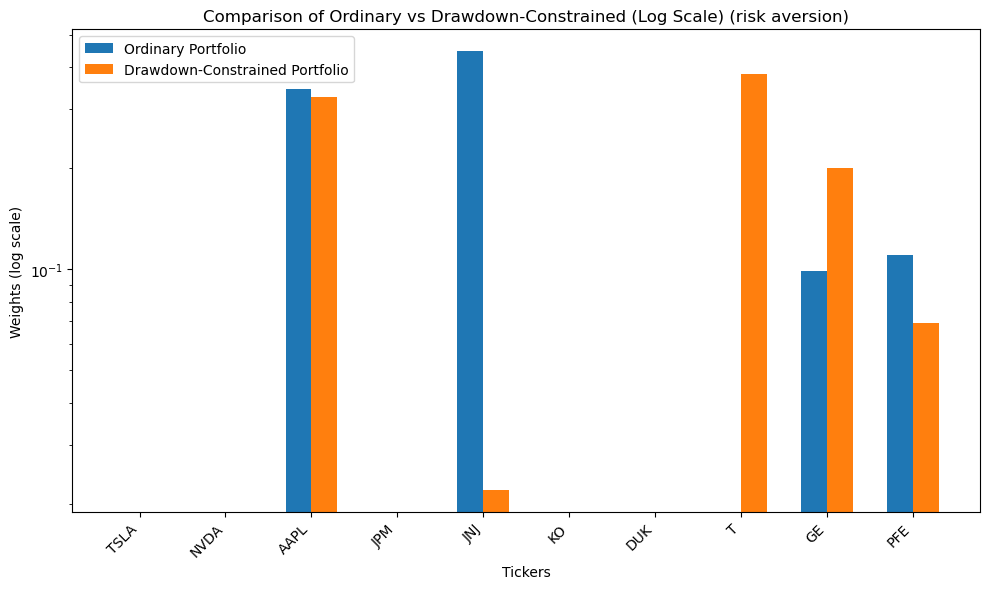

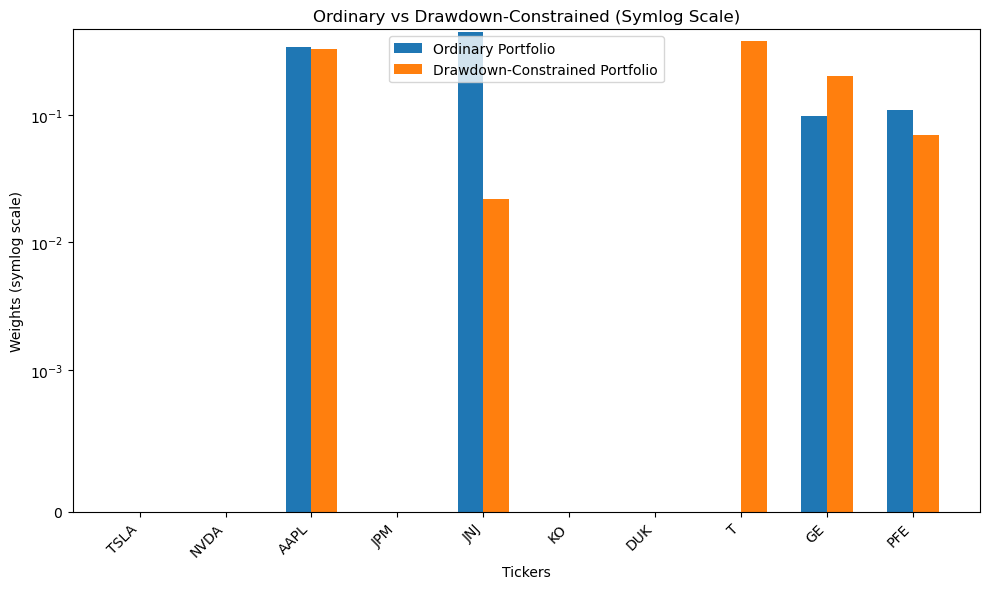

In [55]:
portfolios = result_df.index
assets = result_df.columns
n_assets = len(assets)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
indices = np.arange(n_assets)

ax.bar(indices - bar_width/2,
       result_df.iloc[0],
       width=bar_width,
       label=portfolios[0])

ax.bar(indices + bar_width/2,
       result_df.iloc[1],
       width=bar_width,
       label=portfolios[1])

ax.set_xticks(indices)
ax.set_xticklabels(assets, rotation=45, ha='right')
ax.set_xlabel("Tickers")
ax.set_ylabel("Weights (log scale)")
ax.set_title("Comparison of Ordinary vs Drawdown-Constrained (Log Scale) (risk aversion)")


ax.set_yscale("log")

ax.legend()
plt.tight_layout()
plt.show()



portfolios = result_df.index
assets = result_df.columns
n_assets = len(assets)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.3
indices = np.arange(n_assets)

ax.bar(indices - bar_width/2,
       result_df.iloc[0],
       width=bar_width,
       label=portfolios[0])

ax.bar(indices + bar_width/2,
       result_df.iloc[1],
       width=bar_width,
       label=portfolios[1])

ax.set_xticks(indices)
ax.set_xticklabels(assets, rotation=45, ha='right')
ax.set_xlabel("Tickers")
ax.set_ylabel("Weights (symlog scale)")
ax.set_title("Ordinary vs Drawdown-Constrained (Symlog Scale)")


ax.set_yscale("symlog", linthresh=1e-3)

ax.legend()
plt.tight_layout()
plt.show()